In [304]:
import numpy as np 
import student
import riarit
from matplotlib import pyplot as plt
from R_table import R_table
import baselines

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Model definition

In [2]:
ex_type=np.array([[0.7,0.4,0,0,0,0.5],
    [0.7,0.6,0.3,0,0,0.5],
    [0.7,0.7,0.6,0,0,0.5],
    [1,0.7,0.6,0.5,0.3,0.7],
    [1,0.9,0.7,0.7,0.5,0.7],
    [1,1,1,1,1,1]])

price_presentation=np.array([[0.8,1,1,1,1,0.2],
    [1,1,1,1,1,0.6],
    [0.9,1,1,1,1,1]])

cents_notation=np.array([[0.8,1,1,1,1,1],
    [0.9,1,1,1,1,1]])

money_type=np.array([[1,1,1,0.9,0.9,1],
    [0.1,1,1,1,1,1]]) # 1 for not relevent value (will be ignored in the R_table)

#### Parameters

## Check Riarit behavior, which arm is preferred ?

In [13]:
def gen_w_a_iter(current_student,method):
    if method == "Random":
        reward_list,_,activity_list,c_hat,c_true,w_a_history,_ = \
            riarit.Exp3(current_student,T,R_table_model,alpha_c_hat,1,compute_regret=False)

    elif method == 'Riarit':
        reward_list,_,activity_list,c_hat,c_true,w_a_history,_ = \
            riarit.Exp3(current_student,T,R_table_model,alpha_c_hat,gamma,compute_regret=False)

    else:
        return
    
    return w_a_history,activity_list,c_true,c_hat


In [15]:
to_test=["Random","Riarit"]
w_a_mean={method : None for method in to_test}
n_itr=50
T=500
activities={method:np.zeros((n_itr,T,n_p)) for method in to_test}
c_true_list=[]
for i in range(n_itr):
    #print "Iteration : {}/{}".format(i+1,n_itr),end='\r'
    for method in to_test:
        current_student=student.Student(R_table_model,initKC,learning_rates,alpha,beta,lambdas=None)
        w_a_history,activities[method][i,:,:],c_true=gen_w_a_iter(current_student,method)[:3]
        c_true_list.append(c_true)
        if w_a_mean[method] is None:
            w_a_mean[method]=[w_a_history[j]/n_itr for j in range(n_p)]
        else:
            for j in range(n_p):
                w_a_mean[method][j]=w_a_mean[method][j]+w_a_history[j]/n_itr


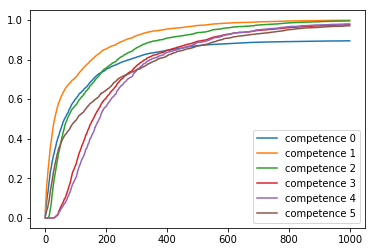

In [160]:
for i in range(n_c):
    
    #plt.plot(c_true_list[50:][i,:])
    
    plt.plot(np.mean([c_true_list[n_itr+j][i,:] for j in range (n_itr)],axis=0),label="competence %d"%i)

plt.legend()
plt.show()

In [161]:
np.mean([[1,2],[1,3]],axis=0)

array([ 1. ,  2.5])

### Plot mean w_a and activity most often given at each time

************************************************************************
Random
************************************************************************


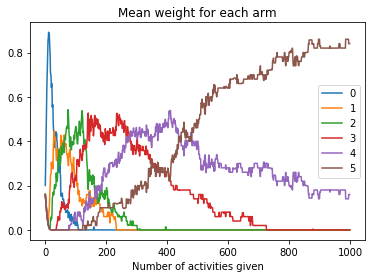

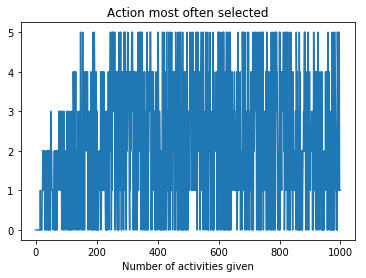

************************************************************************
Riarit
************************************************************************


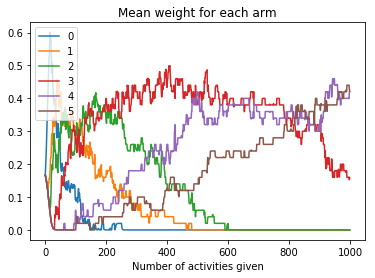

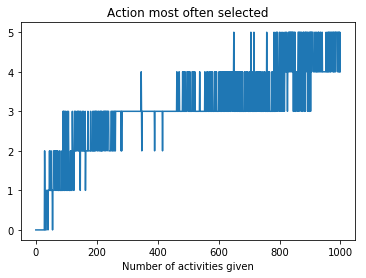

In [162]:
param=0
n_a=R_table_model.n_a[param]
res={method : np.zeros((n_a,T)) for method in to_test}

for method in to_test:
    print("************************************************************************")
    print(method)
    print("************************************************************************")

    plt.figure()
    plt.plot(w_a_mean[method][0])
    plt.legend(["{}".format(i) for i in range(R_table_model.n_a[0])])
    plt.title("Mean weight for each arm")
    plt.xlabel("Number of activities given")
    plt.show()
    
    for i in range(n_a): # all possible values of parameter 
        res[method][i,:]=np.sum(activities[method][:,:,param]==i,axis=0)

    plt.figure()
    plt.title("Action most often selected")
    plt.plot(np.argmax(res[method],axis=0))
    plt.xlabel("Number of activities given")

    plt.show()

Better exploration for Random as expected

# Average evolution of KC for one student for 3 methods

In [270]:
        
T = 150 # number of rounds
n_c = 6 # KnowMoney IntSum IntDec DecSum DecDec Memory 

gamma = 0.2

alpha_c_hat = 0.3

R_table_model=R_table([ex_type,price_presentation,cents_notation,money_type])
initKC = np.zeros(n_c)
n_p=R_table_model.n_p
learning_rates = np.random.uniform(low =0.1,high =0.2,size=n_c)


success_prob=0.8 # probability of sucess when KC=R_table
alpha=np.log(success_prob/(1-success_prob))
beta = 8

beta_w = 1 ## coefficient of the previous value w_a
eta_w = 0.2 ## learning rate for w_a
 

In [282]:
# %% Plot the evolution of competences  for one student 
gamma=0.2
initKC=0.7*np.ones(n_c)
def gen_progresses_iter(current_student,method,T,alpha_c_hat,gamma):
    """
    Generate one iteration of giving T activity to one student with method
    returns the KC of the student function of time

    """
    
    if method == "Predefined sequence":
        activity_list,c_true,correct_answers= \
            baselines.predefined_sequence(current_student,R_table_model,T)
        c_hat=0
        return c_true,c_hat, np.sum(correct_answers)

    elif method == "Random":
        reward_list,regret_list,activity_list,c_hat,c_true,_,_,correct_answers = \
            riarit.Exp3(current_student,T,R_table_model,alpha_c_hat,1,compute_regret=False)
    
        return c_true,c_hat,reward_list,regret_list
    
    elif method == 'Riarit':
        reward_list,regret_list,activity_list,c_hat,c_true,_,_,correct_answers = \
            riarit.Exp3(current_student,T,R_table_model,alpha_c_hat,gamma,compute_regret=False)
        
        return c_true,c_hat,reward_list,regret_list,correct_answers
    else:
        return
    
    
    

In [207]:
n_itr=50
T=250
methods=["Predefined sequence","Random","Exp3"]
true_KC = {method : None for method in methods}
KC_hat = {method : None for method in methods}
activities = {method : None for method in methods}
for i in range(n_itr):
    #print("Iteration : {}/{}".format(i+1,n_itr),end='\r')
    for method in methods:            
        current_student=student.Student(R_table_model,initKC,learning_rates,alpha,beta,lambdas=None)
        KC_iter,KC_hat_iter=gen_progresses_iter(current_student,method,T,alpha_c_hat,gamma)[:2]
        if true_KC[method] is None:
            true_KC[method]=KC_iter/n_itr 
        else:
            true_KC[method]=true_KC[method]+KC_iter/n_itr
            
        if KC_hat[method] is None:
            KC_hat[method]=KC_hat_iter/n_itr
        else :
            KC_hat[method]=KC_hat[method]+KC_hat_iter/n_itr
            
            

In [241]:
M=["Predefined sequence","Random","Exp3"]

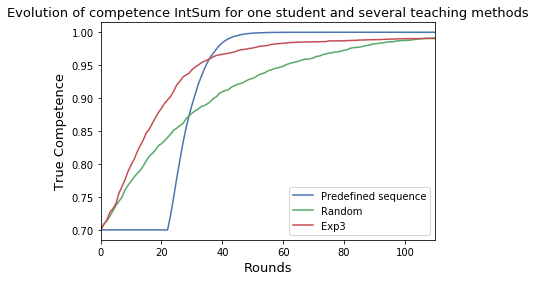

In [251]:
for c in range(1,2):
    plt.figure()
    i=0
    for method in methods:
        plt.plot(true_KC[method][c],label=M[i])
        i+=1
    plt.legend()
    plt.title("Evolution of competence IntSum for one student and several teaching methods",fontsize=13)
    plt.xlabel('Rounds',fontsize=13)
    plt.ylabel('True Competence',fontsize=13)
    plt.xlim((0,110))
    plt.show ()

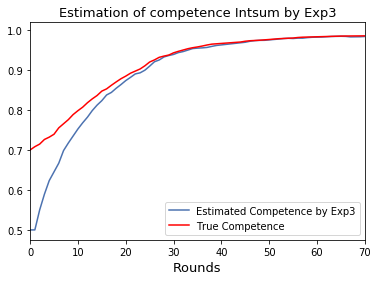

In [255]:
for c in range(1,2):
    plt.figure()
    
    plt.plot(KC_hat['Riarit'][c],label='Estimated Competence by Exp3')
    plt.plot(true_KC['Riarit'][c],label='True Competence',color='red')
    plt.legend()
    plt.title("Estimation of competence Intsum by Exp3",fontsize=13)
    plt.xlim((0,70))
    plt.xlabel('Rounds',fontsize=13)
    
    
    plt.show ()

In [271]:
reward_av = {method : None for method in methods}
regret_av = {method : None for method in methods}
for i in range(n_itr):
    
    for method in methods[-2:]:
        
        current_student=student.Student(R_table_model,initKC,learning_rates,alpha,beta,lambdas=None)
        reward_list,regret_list = gen_progresses_iter(current_student,method,T,alpha_c_hat,gamma)[2:4]
        
        if reward_av[method] is None:
            reward_av[method] = np.cumsum(reward_list)/n_itr
        else : 
            reward_av[method] =reward_av[method]+ np.cumsum(reward_list)/n_itr
        
        if regret_av[method] is None:
            regret_av[method] = regret_list/n_itr
        else : 
            regret_av[method] =regret_av[method] + regret_list/n_itr
            
            
    
    
    

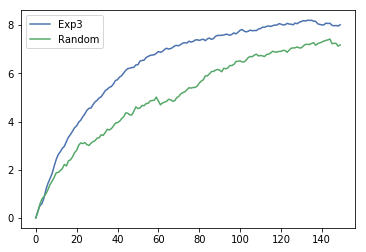

In [261]:
plt.plot(reward_av['Riarit'],label='Exp3')
plt.plot(reward_av['Random'],label='Random')

plt.legend()
plt.show()

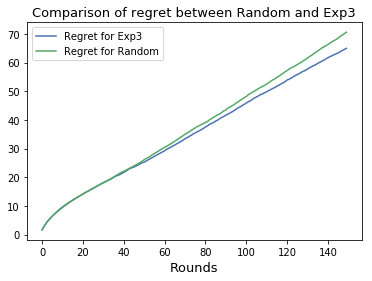

In [272]:
plt.plot(regret_av['Riarit'],label='Regret for Exp3')
plt.plot(regret_av['Random'],label='Regret for Random')
plt.title('Comparison of regret between Random and Exp3',fontsize=13)
plt.xlabel('Rounds',fontsize=13)
plt.legend()
plt.show()

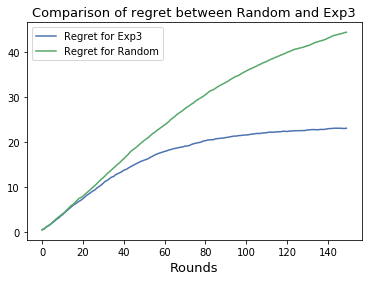

In [265]:
plt.plot(regret_av['Riarit'],label='Regret for Exp3')
plt.plot(regret_av['Random'],label='Regret for Random')
plt.title('Comparison of regret between Random and Exp3',fontsize=13)
plt.xlabel('Rounds',fontsize=13)
plt.legend()
plt.show()

###################################
Scenario : 

Top student with initial KC=0.7 but underrated by the professor who believes his KC=0.5 (in all competences). For the sake of clarity, We only focus on the progress related to competence n°1.

Given the advanced level of the student, only the two most difficult exercises (difficulty 5 and 6) can make him progress. (the other parameters are irrelevant for competence 1 because there all equal to 1 --> makes interpretation much easier)

####################################
Interpretation of the true progress curves:

Random : Significantly less efficent : Needs the double number of iterations to converge to 1.

Predefined Sequence : Don't take into account the a priori on the student level --> waste time and risk of boring the student by giving too easy exercises : no progress before 25 exercises! ++ other Risk : if the student needs specific exercises to progress that are not contained in the predefined sequence (this sequence cannot contain all the possible exercises, too many). Here, it's not the case, the last two exercises of the sequence are the one needed by the student, hence the  fast progress.

Exp3 : Propose relevant exercises faster than predefined sequence by correcting its underestimation of the student level. But it's forced to keep exploring (20%) wich explains why progress are less brutal than for predefined sequence.



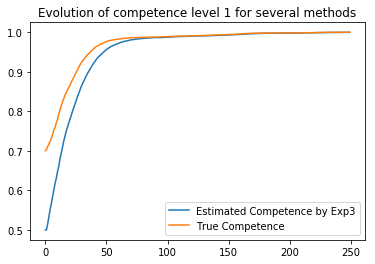

In [73]:
for c in range(1,2):
    plt.figure()
    
    plt.plot(KC_hat['Riarit'][c],label='Estimated Competence by Exp3')
    plt.plot(true_KC['Riarit'][c],label='True Competence')
    plt.legend()
    plt.title("Evolution of competence level {} for several methods".format(c))
    plt.show ()

Exp3 corrects its inital underestimation of the student competence : blue curve catches up the orange curve.

In [53]:
reward_av = {method : None for method in methods}
regret_av = {method : None for method in methods}
for i in range(n_itr):
    
    for method in methods[-2:]:
        
        current_student=student.Student(R_table_model,initKC,learning_rates,alpha,beta,lambdas=None)
        reward_list,regret_list = gen_progresses_iter(current_student,method,T,alpha_c_hat,gamma)[-2:]
        
        if reward_av[method] is None:
            reward_av[method] = np.cumsum(reward_list)/n_itr
        else : 
            reward_av[method] =reward_av[method]+ np.cumsum(reward_list)/n_itr
        
        if regret_av[method] is None:
            regret_av[method] = regret_list/n_itr
        else : 
            regret_av[method] =regret_av[method] + regret_list/n_itr
            
            
    
    
    

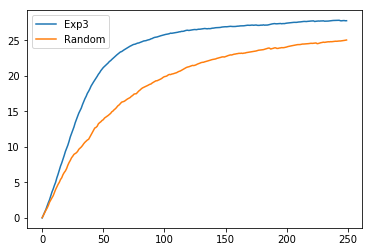

In [67]:
plt.plot(reward_av['Riarit'],label='Exp3')
plt.plot(reward_av['Random'],label='Random')

plt.legend()
plt.show()

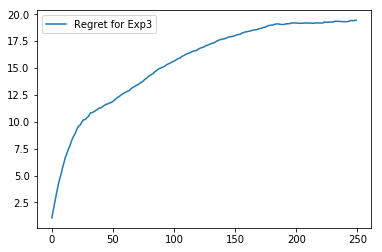

In [59]:
plt.plot(regret_av['Riarit'],label='Regret for Exp3')
plt.legend()
plt.show()

Regret compared to the optimal policiy wich consists in proposing exercise of difficulty 5 up to a certain moment (computed by maximizing expected reward) then propose difficulty 6 to the end?

2 phases :

1) strong slope : the regret rises rapidly because the estimation of the KC is still underrated and not corrected yet --> Exp3 propose too easy exercisese

2) the slope diminishes because the estimation of KC is more accurate --> exp3 propose relevant exercises.

# Classrooms test

#### Students definition

In [372]:
pstudents=[]
nb_students=50
T = 50 # number of rounds
n_c = 6 # KnowMoney IntSum IntDec DecSum DecDec Memory 
R_table_model=R_table([ex_type,price_presentation,cents_notation,money_type])
n_p=R_table_model.n_p

###########################################################################
# These parameters can vary depending on the student but not for now 
success_prob=0.8 # probability of sucess when KC=R_table
alpha=np.log(success_prob/(1-success_prob))
beta = 8
###########################################################################


for i in range(nb_students):
    ######## PARAMETERS THAT VARY FOR EACH STUDENT #################
    initKC = np.random.uniform(low=0,high=0.5,size=n_c)
    initKC = np.clip(np.random.normal(loc=0.5,scale = 0.1,size=n_c),0,1)
    learning_rates = np.random.uniform(low =0.0001,high =0.005,size=n_c)
    ################################################################
    
    pstudents.append(student.Student(R_table_model,initKC,learning_rates,alpha,beta,lambdas=None))
    

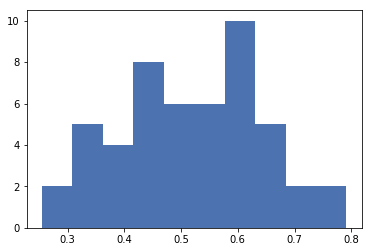

In [373]:
init_KC_class = np.zeros((nb_students,n_c))
for s in range(nb_students):
    init_KC_class[s,:]=pstudents[s].KC

for c in range(1,2):
    plt.hist(init_KC_class[:,c])
    plt.show()

In [218]:

{method : np.zeros(5) for method in methods}


{'Predefined sequence': array([ 0.,  0.,  0.,  0.,  0.]),
 'Random': array([ 0.,  0.,  0.,  0.,  0.]),
 'Riarit': array([ 0.,  0.,  0.,  0.,  0.])}

In [374]:
# Riarit parameters :
gamma=0.2
n_itr=50
T=50
methods=["Predefined sequence","Random","Riarit"]

# Iterations for each student and each methods
final_KC={method : list(init_KC_class/n_itr) for method in methods}
answers = {method : np.zeros(nb_students) for method in methods}

for i,c_student in enumerate(pstudents):
    
    print i
    
    for method in methods[0::2]:
        for iteration in range(n_itr):
        
            final_KC[method][i]+=gen_progresses_iter(c_student,method,T,alpha_c_hat,gamma)[0][:,-1]/n_itr
            answers[method][i]+= float(gen_progresses_iter(c_student,method,T,alpha_c_hat,gamma)[-1])/n_itr
        c_student.reset()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


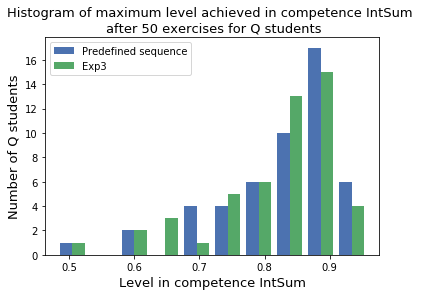

In [366]:
plt.style.use('seaborn-deep')

for c in range(1,2):

    data=[]
    for method in methods[0::2]:
        data.append(np.array(final_KC[method])[:,c])

    data = np.vstack(data).T

    plt.hist(data,label=M[0::2])
    plt.title('Histogram of maximum level achieved in competence IntSum \n after 50 exercises for Q students',fontsize=13)
    plt.ylabel('Number of Q students',fontsize=13)
    plt.xlabel('Level in competence IntSum',fontsize=13)
    plt.legend()
    plt.show()

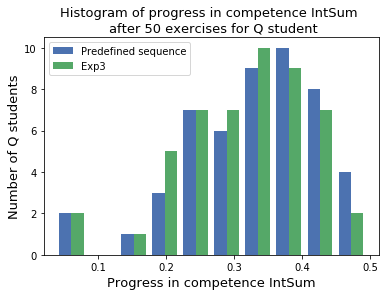

In [367]:
plt.style.use('seaborn-deep')

for c in range(1,2):

    data=[]
    for method in methods[0::2]:
        data.append(np.array(final_KC[method])[:,c]-init_KC_class[:,c])

    data = np.vstack(data).T

    plt.hist(data,label=M[0::2]) 
    plt.legend()
    plt.title('Histogram of progress in competence IntSum \n after 50 exercises for Q student',fontsize=13)
    plt.ylabel('Number of Q students',fontsize=13)
    plt.xlabel('Progress in competence IntSum',fontsize=13)
    plt.show()

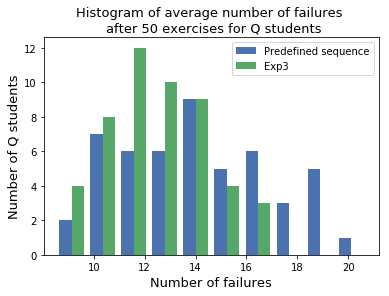

In [375]:
data=[]
for method in methods[0::2]:
    data.append(T-answers[method])
data = np.vstack(data).T

plt.hist(data,label=M[0::2]) 
plt.legend()
plt.title('Histogram of average number of failures \n after 50 exercises for Q students',fontsize=13)
plt.xlabel('Number of failures',fontsize=13)
plt.ylabel('Number of Q students',fontsize=13)
plt.show()

Now that we're sure that riarit provides good progress, we can look at the number of failures and interpret it the following way : the less the better, the more adaptable. (we know that riarit does not provide too easy exercises):


Less errors with Riarit because it adapts to the student level : the errors comes from the beginning, period when the algorithm learn the level of the student.
On the contrary, predefined-sequence is less fexible. In the sequence, the level of difficulty of each exercises is growing at the same pace for each comptence but some students learn much slowly a specific competence so that this 'uniform pace' does not suit them --> more important number of failures --> risk of frustration.


# Test with Q-students

In [322]:
qstudents=[]
nb_students=50
T = 50 # number of rounds
n_c = 6 # KnowMoney IntSum IntDec DecSum DecDec Memory 
R_table_model=R_table([ex_type,price_presentation,cents_notation,money_type])
n_p=R_table_model.n_p
n_a_list = R_table_model.n_a
###########################################################################
# These parameters can vary depending on the student but not for now 
success_prob=0.8 # probability of sucess when KC=R_table
alpha=np.log(success_prob/(1-success_prob))
beta = 8
###########################################################################
nb_block = 5

for i in range(nb_students):
    ######## PARAMETERS THAT VARY FOR EACH STUDENT #################
    initKC = np.random.uniform(low=0,high=0.5,size=n_c)
    initKC = np.clip(np.random.normal(loc=0.5,scale = 0.1,size=n_c),0,1)
    learning_rates = np.random.uniform(low =0.0001,high =0.01,size=n_c)
    ################################################################
    random_activity_list = [np.array([np.random.choice(n_a) for n_a in n_a_list]) for i in range(nb_block)]
    qstudents.append(student.Student(R_table_model,initKC,learning_rates,alpha,beta,lambdas=random_activity_list))
    

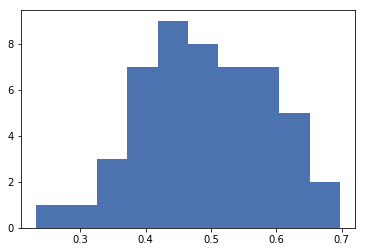

In [323]:
init_KC_class = np.zeros((nb_students,n_c))
for s in range(nb_students):
    init_KC_class[s,:]=qstudents[s].KC

for c in range(1,2):
    plt.hist(init_KC_class[:,c])
    plt.show()

In [324]:
gamma=0.2
n_itr=50
T=50
methods=["Predefined sequence","Random","Riarit"]

# Iterations for each student and each methods
final_KC={method : list(init_KC_class/n_itr) for method in methods}
answers = {method : np.zeros(nb_students) for method in methods}

for i,c_student in enumerate(qstudents):
    
    print i
    
    for method in methods[0::2]:
        for iteration in range(n_itr):
        
            final_KC[method][i]+=gen_progresses_iter(c_student,method,T,alpha_c_hat,gamma)[0][:,-1]/n_itr
            answers[method][i]+= float(gen_progresses_iter(c_student,method,T,alpha_c_hat,gamma)[-1])/n_itr
        c_student.reset()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


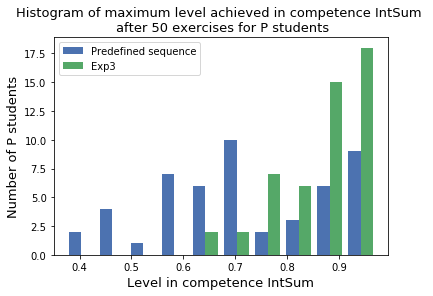

In [327]:
plt.style.use('seaborn-deep')

for c in range(1,2):

    data=[]
    for method in methods[0::2]:
        data.append(np.array(final_KC[method])[:,c])

    data = np.vstack(data).T
    plt.title('Histogram of maximum level achieved in competence IntSum \n after 50 exercises for P students',fontsize=13)
    plt.ylabel('Number of P students',fontsize=13)
    plt.xlabel('Level in competence IntSum',fontsize=13)
    plt.hist(data,label=M[0::2]) 
    plt.legend()
    plt.show()

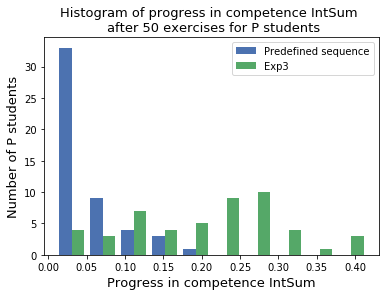

In [331]:
plt.style.use('seaborn-deep')

for c in range(5,6):

    data=[]
    for method in methods[0::2]:
        data.append(np.array(final_KC[method])[:,c]-init_KC_class[:,c])

    data = np.vstack(data).T

    plt.hist(data,label= M[0::2]) 
    plt.legend()
    plt.title('Histogram of progress in competence IntSum \n after 50 exercises for P students',fontsize=13)
    plt.ylabel('Number of P students',fontsize=13)
    plt.xlabel('Progress in competence IntSum',fontsize=13)
    
    plt.show()

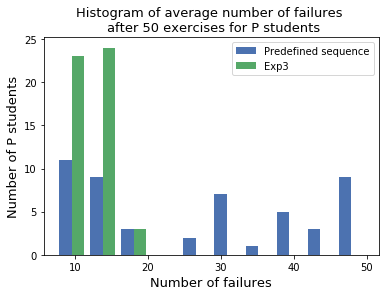

In [332]:
data=[]
for method in methods[0::2]:
    data.append(T-answers[method])
data = np.vstack(data).T

plt.hist(data,label=M[0::2]) 
plt.legend()
plt.title('Histogram of average number of failures \n after 50 exercises for P students',fontsize=13)
plt.xlabel('Number of failures',fontsize=13)
plt.ylabel('Number of P students',fontsize=13)
plt.show()

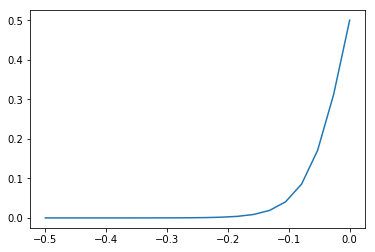

In [171]:
x= np.linspace(-0.5,0,20)
plt.plot(x,1./(1+np.exp(-30*x)))
plt.show()

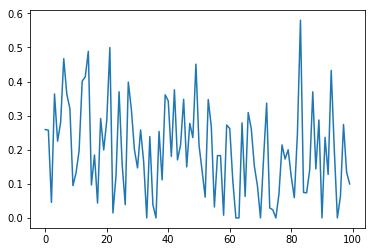

In [80]:
plt.plot(np.clip(np.random.normal(loc=0.2,scale = 0.15,size=100),0,1))
plt.show()